In [9]:
#path to the required call analysis file
path_to_file="/Users/pravin/Desktop/Src/call_analysis_results.csv"

In [4]:
import os
import re
from openai import OpenAI

# Path to the folder containing the transcript files
folder_path = '/Users/pravin/Desktop/transcripts_v3/transcripts_v3'

# Function to load all transcripts
def load_transcripts(folder_path):
    transcripts = []
    # List and sort the filenames in ascending order
    filenames = sorted([filename for filename in os.listdir(folder_path) if filename.endswith(".txt")])
    
    # Load each transcript file in the sorted order
    for filename in filenames:
        with open(os.path.join(folder_path, filename), 'r') as file:
            transcripts.append({filename:file.read()})
    return transcripts

# Load all transcript files
transcripts = load_transcripts(folder_path)
print(f"Loaded {len(transcripts)} transcripts.")
# Function to extract the numerical part of the filename
def extract_number(key):
    return int(re.search(r'\d+', key).group())

# Sort the transcripts based on the number in the filename
sorted_transcripts = sorted(transcripts, key=lambda x: extract_number(list(x.keys())[0]))
sorted_transcripts[:5]

Loaded 200 transcripts.


[{'transcript_0.txt': "Member: Hi, I'm calling to get a case pre-authorized. My name is Emily Wilson and my member ID is MEM456789.\n\nPA Agent: Hi Emily, thank you for calling PA customer care. Can you please confirm your date of birth for verification purposes?\n\nMember: It's March 12, 1985.\n\nPA Agent: Thank you, Emily. Can you please provide me with some details about the case you're seeking pre-authorization for? What's the nature of the treatment or service you're looking to receive?\n\nMember: I'm scheduled to undergo an MRI scan for a knee injury. My doctor's office has already submitted the request, but I wanted to confirm the status and ensure that it's covered under my plan.\n\nPA Agent: I apologize for the delay, Emily. Let me just check on the status of your request. Can you please hold for just a moment?\n\nMember: Sure, thank you.\n\nPA Agent: Thank you for holding, Emily. I've located your request and I'm reviewing the details now. Can you please confirm the name of y

Building ground truth data using LLM

In [5]:
def build_prompt(transcript):
    prompt_template = f"""
    
    The following is a conversation between a customer and an agent. Analyze the conversation and do the following:

    1. Determine if the customer's issue was resolved or if follow-up action is needed.
    2. Determine the overall sentiment of the customer during the conversation (positive, negative, or neutral).

    Transcript: {transcript}

    Based on the findings provide an output in the below format:

    Call Outcome: [Issue Resolved/Follow-up Action Needed]
    Sentiment: [Positive/Negative/Neutral]
    """
    
    return prompt_template.strip()

In [6]:
# OLLAMA_URL = "http://ollama:11434/v1/"
OLLAMA_URL = "http://localhost:11434/v1/"

def llm(transcript):
    prompt=build_prompt(transcript)
           
    ollama_client = OpenAI(base_url=OLLAMA_URL, api_key="ollama")

    response = ollama_client.chat.completions.create(
                model="llama3.2",
                messages=[{"role": "user", "content": prompt}]
            )
    answer = response.choices[0].message.content
    return answer

In [7]:
from tqdm import tqdm

def determine_call_outcomes(customer_transcripts):
    outcomes = []
    for transcript in tqdm(customer_transcripts, desc="Processing Transcripts"):
        outcome = llm(transcript)  # Reuse the function from earlier
        outcomes.append(outcome)
    return outcomes

In [8]:
# Determine call outcome for each transcript
call_outcomes = determine_call_outcomes(sorted_transcripts)

Processing Transcripts: 100%|██████████| 200/200 [1:45:13<00:00, 31.57s/it]


In [20]:
import pandas as pd

# Read data from CSV file into a DataFrame
df = pd.read_csv(path_to_file)

# Display the first few rows of the DataFrame to check the data
df.head()

,Transcript,Customer Dialogue,Sentiment,Call Outcome,Output
0,"{'transcript_0.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling to get a case pre-authorized. ...",POSITIVE,Call Outcome: Issue Resolved\nSentiment: Neutr...,Issue Resolved
1,"{'transcript_1.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about a denied claim I receive...",NEGATIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed
2,"{'transcript_2.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about my recent doctor's visit...",POSITIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed
3,"{'transcript_3.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about my recent visit to the d...",NEGATIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed
4,"{'transcript_4.txt': ""Member: Hi, I'd like to ...","Hi, I'd like to schedule an appointment with a...",POSITIVE,Call Outcome: Issue Resolved\nSentiment: Posit...,Issue Resolved


In [21]:
df['Ground_truth_outcome'] = call_outcomes

In [22]:
df.head()

,Transcript,Customer Dialogue,Sentiment,Call Outcome,Output,Ground_truth_outcome
0,"{'transcript_0.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling to get a case pre-authorized. ...",POSITIVE,Call Outcome: Issue Resolved\nSentiment: Neutr...,Issue Resolved,"Based on the conversation transcript, here is ..."
1,"{'transcript_1.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about a denied claim I receive...",NEGATIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed,"Based on the transcript, here is my analysis o..."
2,"{'transcript_2.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about my recent doctor's visit...",POSITIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed,"Based on the conversation transcript, here is ..."
3,"{'transcript_3.txt': ""Member: Hi, I'm calling ...","Hi, I'm calling about my recent visit to the d...",NEGATIVE,Call Outcome: Follow-up Action Needed\nSentime...,Follow-up Action Needed,"Based on the transcript, here is the analysis ..."
4,"{'transcript_4.txt': ""Member: Hi, I'd like to ...","Hi, I'd like to schedule an appointment with a...",POSITIVE,Call Outcome: Issue Resolved\nSentiment: Posit...,Issue Resolved,"Based on the conversation transcript, here is ..."


In [23]:
# Define a function to check and categorize the outcome
def categorize_outcome(call_outcome):
    call_outcome_lower = call_outcome.lower()
    if "follow-up" in call_outcome_lower:
        return "Follow-up Action Needed"
    elif "issue" or "resolved" in call_outcome_lower:
        return "Issue Resolved"
    else:
        return "Unknown"
    

# Define a function to check and categorize the outcome
def categorize_sentiment(call_outcome):
    call_outcome_lower = call_outcome.lower()
    if "positive" in call_outcome_lower:
        return "positive"
    elif "negative"  in call_outcome_lower:
        return "negative"
    elif "neutral" in call_outcome_lower:
        return "neutral"
    else:
        return "unknown"

In [24]:
# Apply the function to the 'Call Outcome' column and create a new 'Output' column
df['Actual_Sentiment'] = df['Ground_truth_outcome'].apply(categorize_sentiment)
df['Actual_Outcome'] = df['Ground_truth_outcome'].apply(categorize_outcome)

In [25]:
import csv

# Save results to a CSV file
df.to_csv('call_analysis_ground_truth_results.csv', index=False)
print("Results saved to call_analysis_ground_truth_results.csv")

Results saved to call_analysis_ground_truth_results.csv


In [26]:
from sklearn.metrics import classification_report, accuracy_score
# Assuming we have ground-truth labels for validation
y_true_sentiments = df['Actual_Sentiment']  # Actual sentiments (from a validation set)
y_true_outcomes = df['Actual_Outcome']   # Actual outcomes (from a validation set)

# Model predictions
y_pred_sentiments = df["Sentiment"]
y_pred_outcomes = df["Output"]

# Evaluate sentiment analysis
print(classification_report(y_true_sentiments, y_pred_sentiments))

# Evaluate call outcome classification
print(classification_report(y_true_outcomes, y_pred_outcomes))


              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       0.0
     NEUTRAL       0.00      0.00      0.00       0.0
    POSITIVE       0.00      0.00      0.00       0.0
    negative       0.00      0.00      0.00      27.0
     neutral       0.00      0.00      0.00       8.0
    positive       0.00      0.00      0.00     163.0
     unknown       0.00      0.00      0.00       2.0

    accuracy                           0.00     200.0
   macro avg       0.00      0.00      0.00     200.0
weighted avg       0.00      0.00      0.00     200.0

                         precision    recall  f1-score   support

Follow-up Action Needed       0.61      0.29      0.39       106
         Issue Resolved       0.50      0.79      0.61        94

               accuracy                           0.53       200
              macro avg       0.55      0.54      0.50       200
           weighted avg       0.56      0.53      0.50       200



/opt/anaconda3/envs/mdlmonitoring/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mdlmonitoring/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mdlmonitoring/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

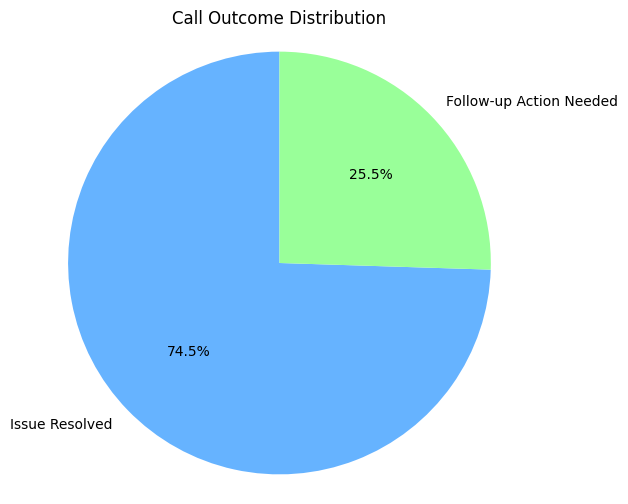

In [29]:
import matplotlib.pyplot as plt

outcome_counts = df['Output'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Title for the chart
plt.title('Call Outcome Distribution')

# Display the chart
plt.show()

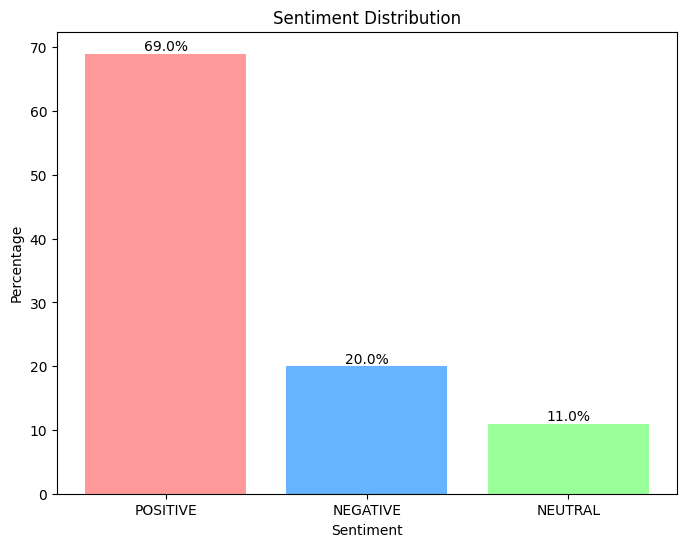

In [30]:
sentiment_counts = df['Sentiment'].value_counts()

# Calculate the percentage
sentiment_percentage = (sentiment_counts / sentiment_counts.sum()) * 100

# Plot a bar chart
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(sentiment_percentage.index, sentiment_percentage, color=['#ff9999','#66b3ff','#99ff99'])

# Add percentage labels on top of the bars
for i, value in enumerate(sentiment_percentage):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center')

# Title and labels
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')

# Display the chart
plt.show()